In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
def params_label(params):
    
    label = '';
    
    for k in params.keys():
        
        v = params[k]
        
        if type(v) == dict:
            label += params_label(v)
        else:

            abb = {
                'optimize_segments':'sopt',
                'prm_build_time': 't_prm',
                'samples_per_goal':'k',
                'timePerAppleSeconds':'tpa',
                'apply_shellstate_optimization':'shopt',
                'useImprovisedSampler':'imp',
                'tryLuckyShots':'l',
                'useCostConvergence':'conv',
                'GreatCircle':'GC'
            }
            
            k = abb.get(k,k)
            

            if type(v) == bool:
                if v:
                    label += '({})'.format(k)
            elif type(v) == str:
                label += '({})'.format(abb.get(v,v))
            else:
                label += '({}:{})'.format(k,v)
    
    return label

In [3]:
with open('full_experiment.json') as f:
    data = json.load(f)
    
track_stats = ['goals_visited', 'final_path_length','run_time']

run_stats = [
    {
        'goals_visited': run['goals_visited'],
        'final_path_length': run['final_path_length'],
        'run_time': run['run_time'],
        'start_state': run['start_state'],
        'scene': run['scene_name'] if run['scene_name'] != '' else 'appletree',
        'planner': run['planner_name'],
        'n': run['napples'],
        'label': params_label(run['planner_params'])
    }
    for run in data if run is not None
]

run_stats = pd.DataFrame(run_stats)
run_stats['length_per_target']= run_stats['final_path_length']/run_stats['goals_visited']
run_stats['pct_n'] = run_stats['goals_visited'] / run_stats['n']

In [4]:
n_unique = run_stats['n'].unique()

In [5]:
agged = run_stats.groupby(
    ['planner','label','scene','n']
)[['goals_visited','run_time','length_per_target','pct_n']].agg(['mean','sem'])

Text(0.5, 1.0, 'Mean goals visited vs runtime')

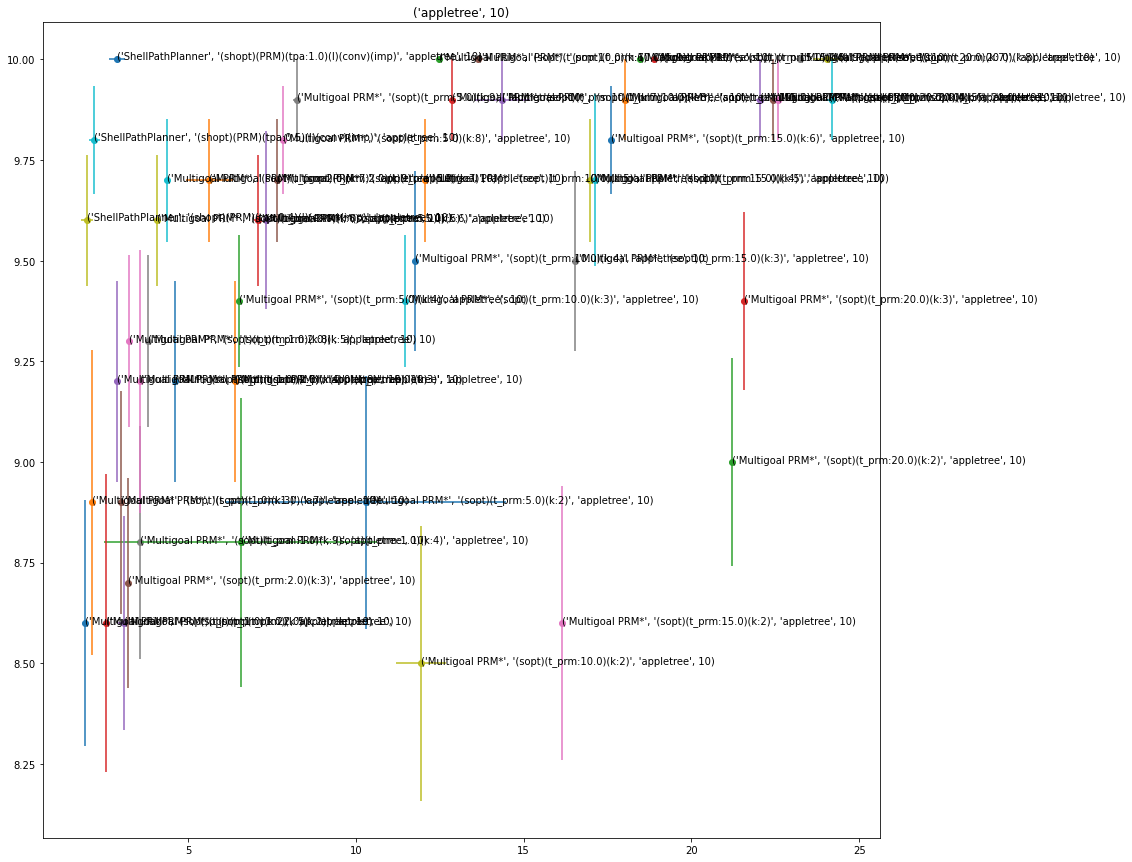

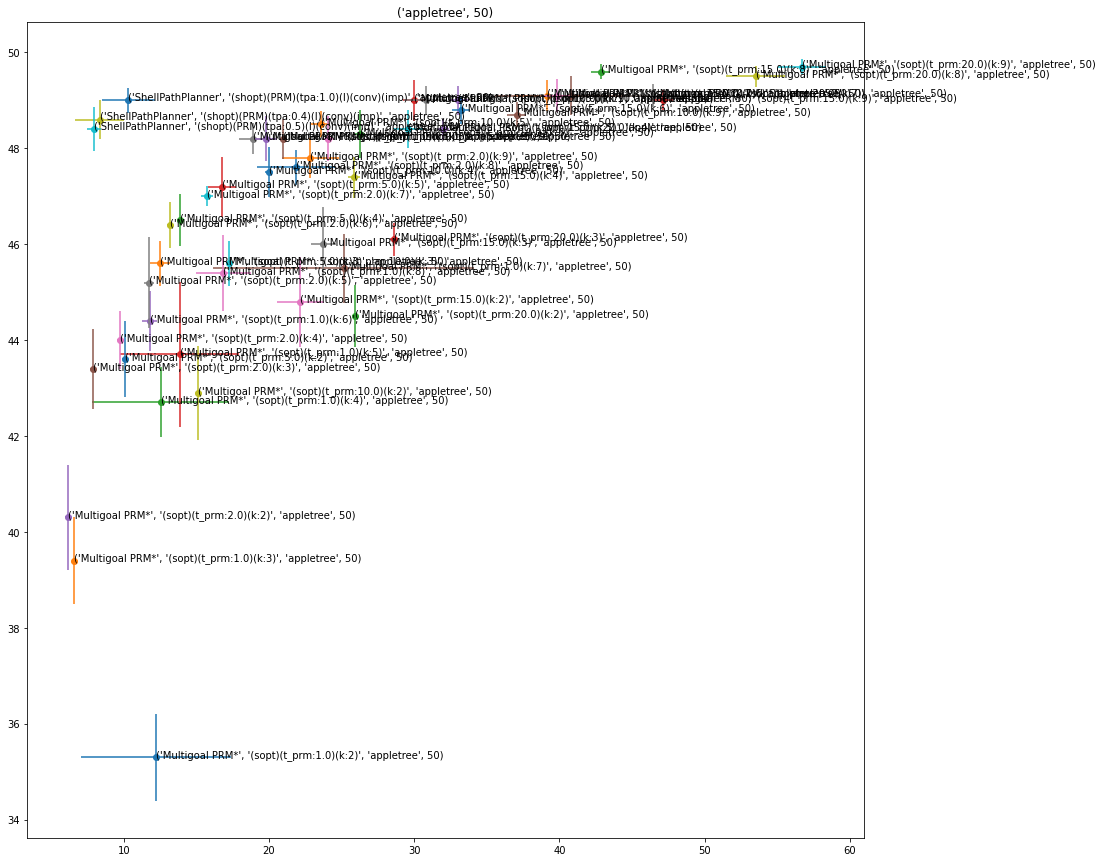

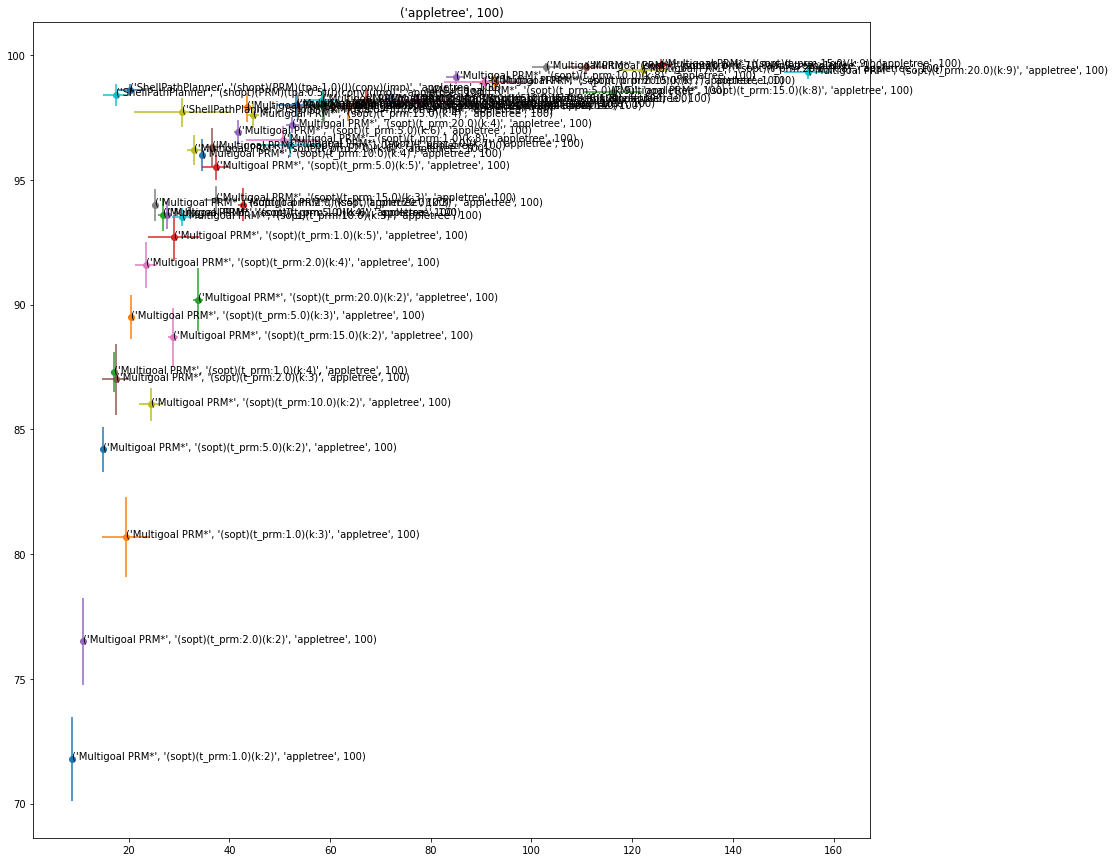

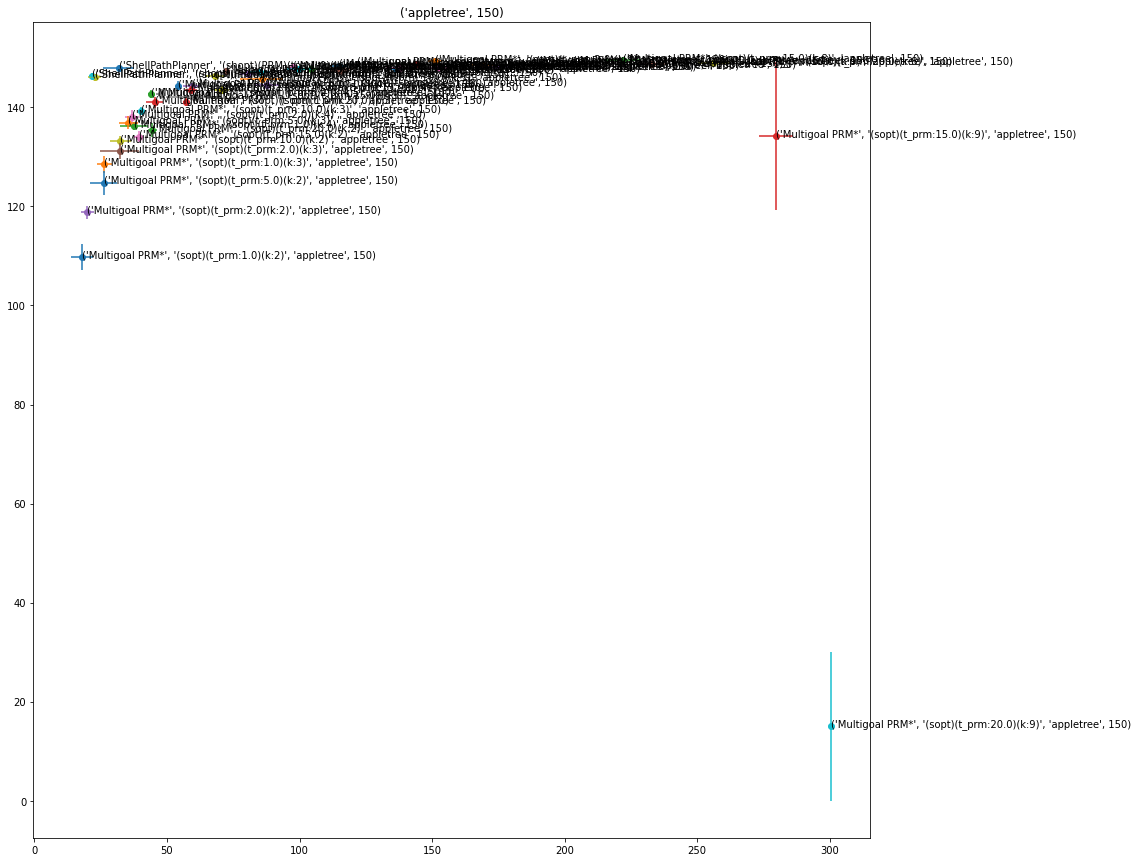

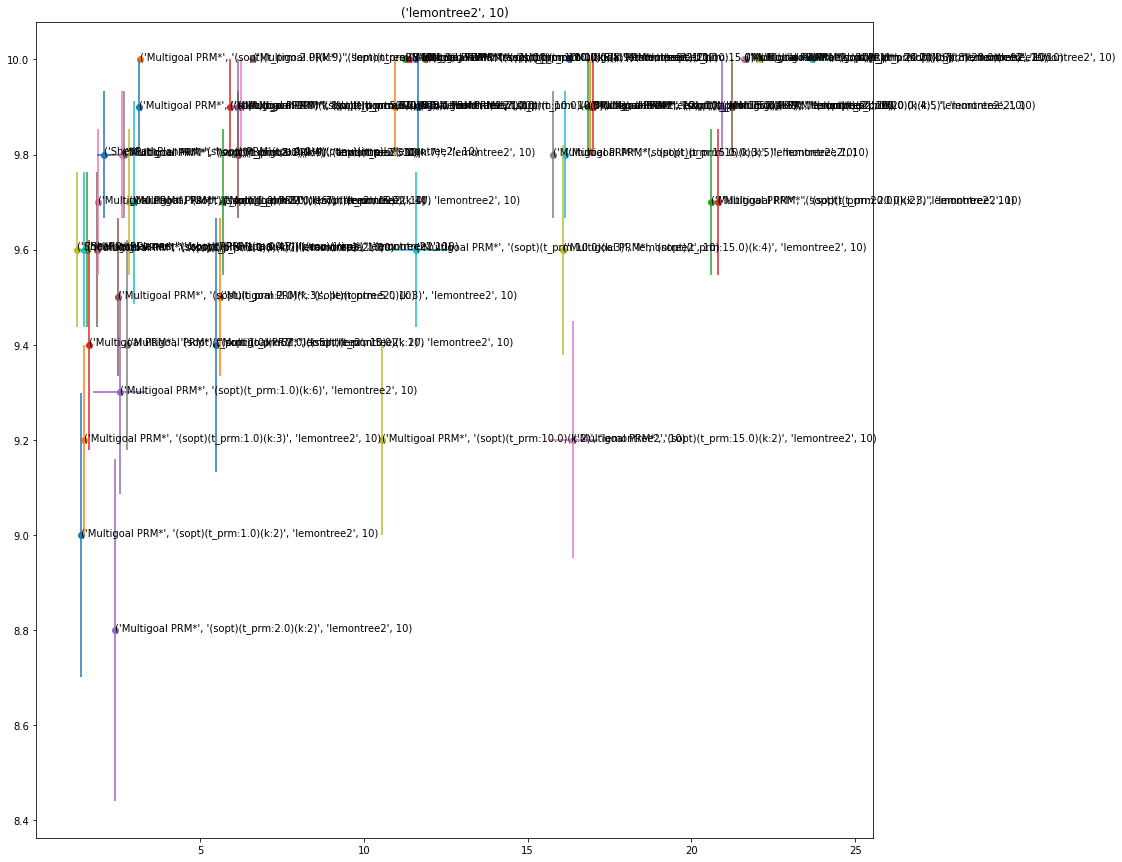

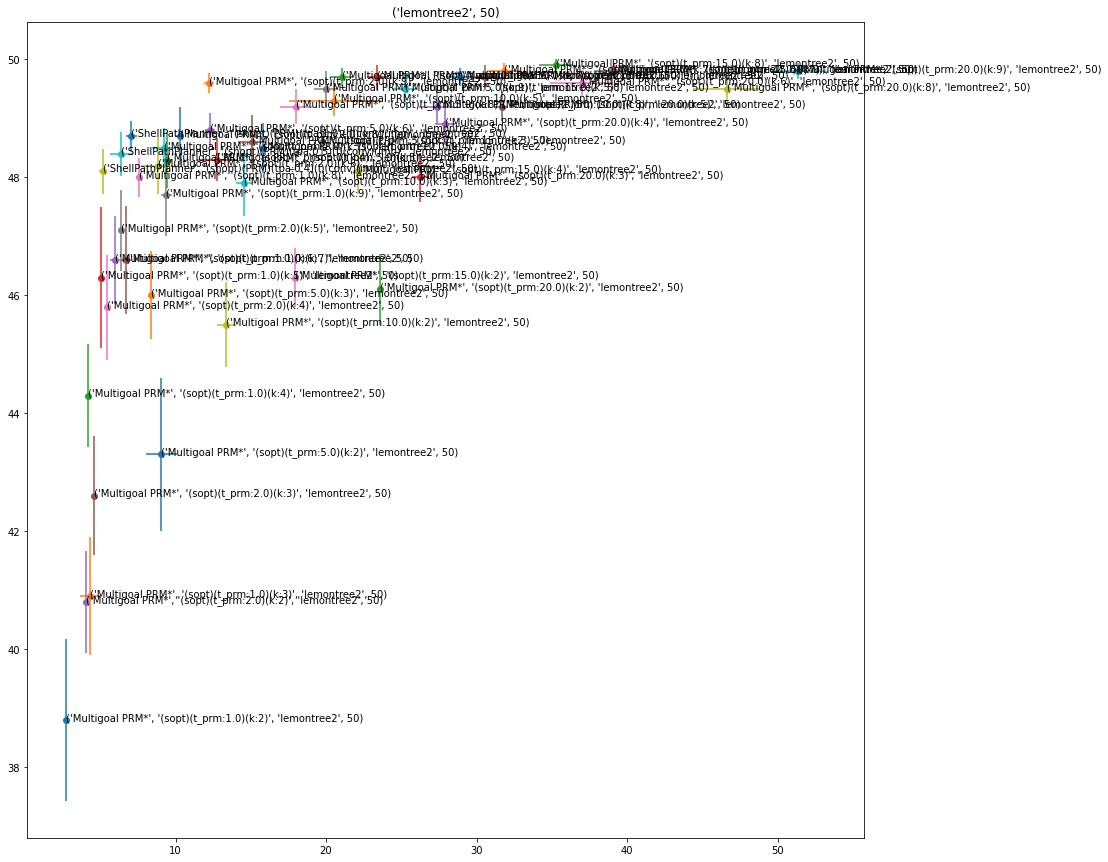

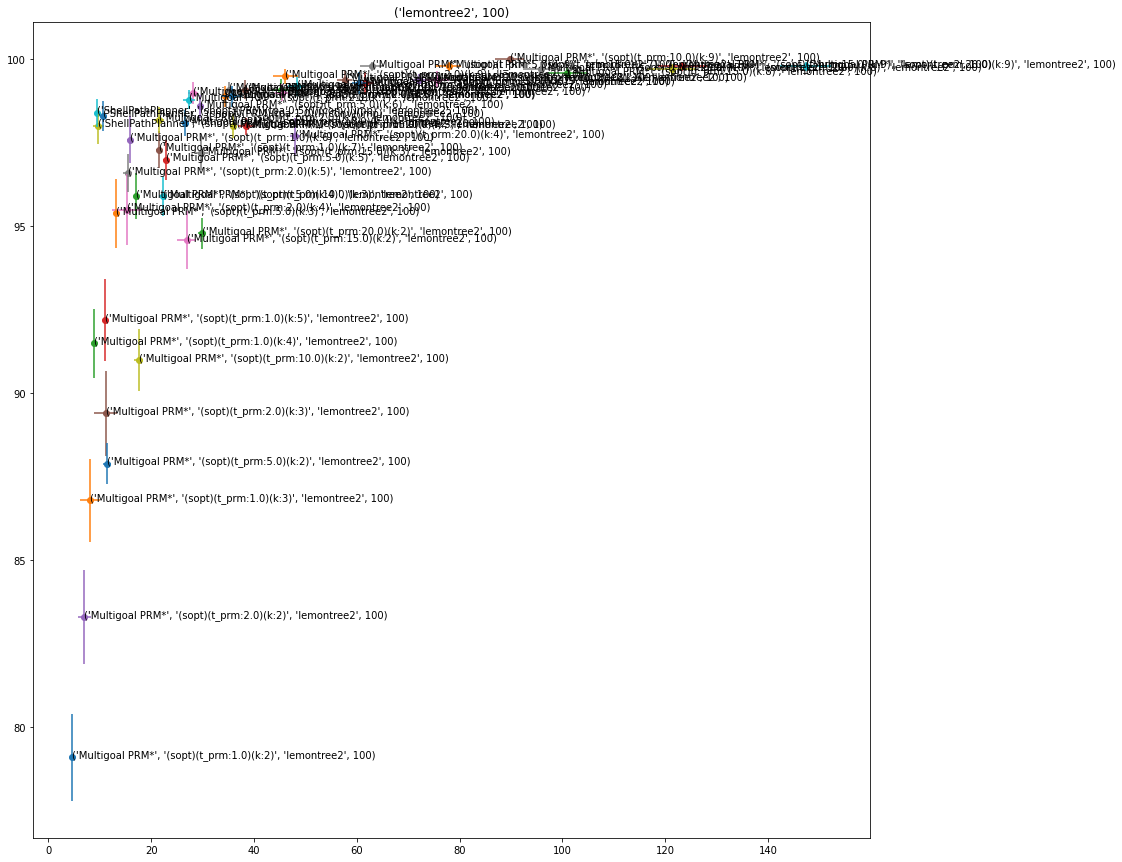

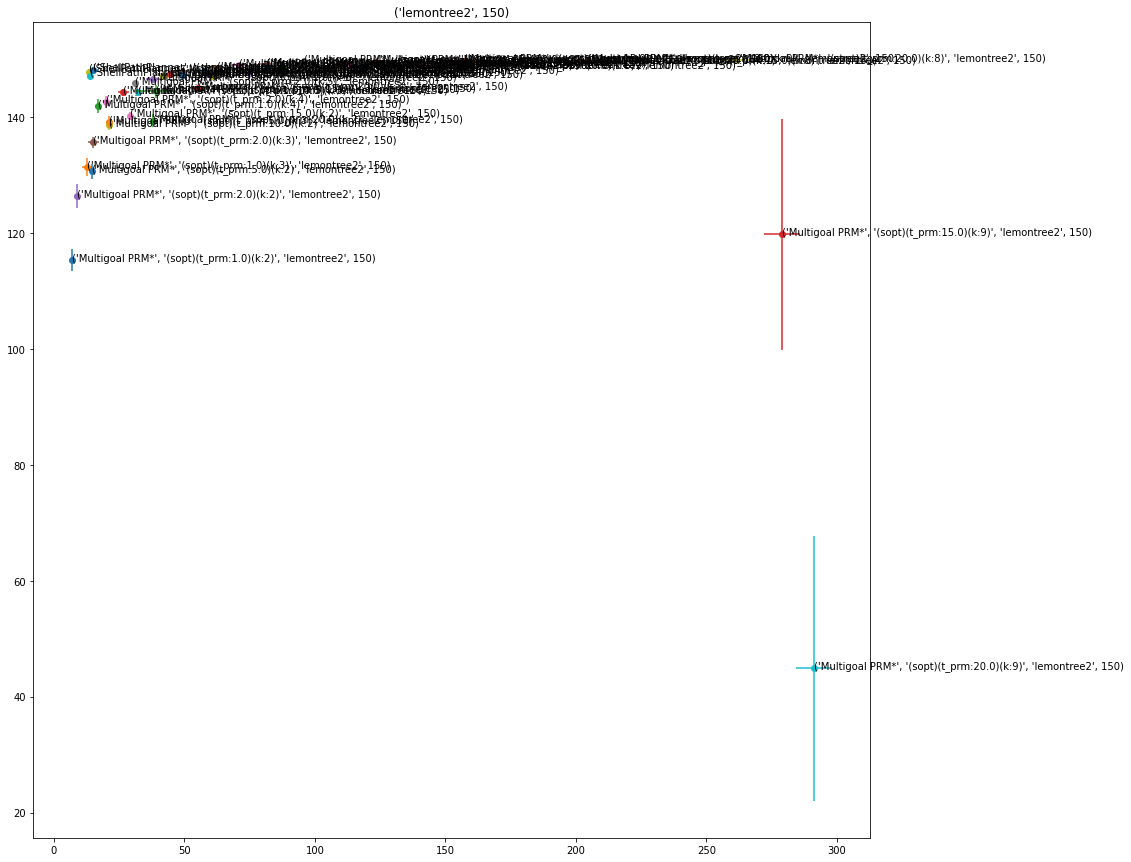

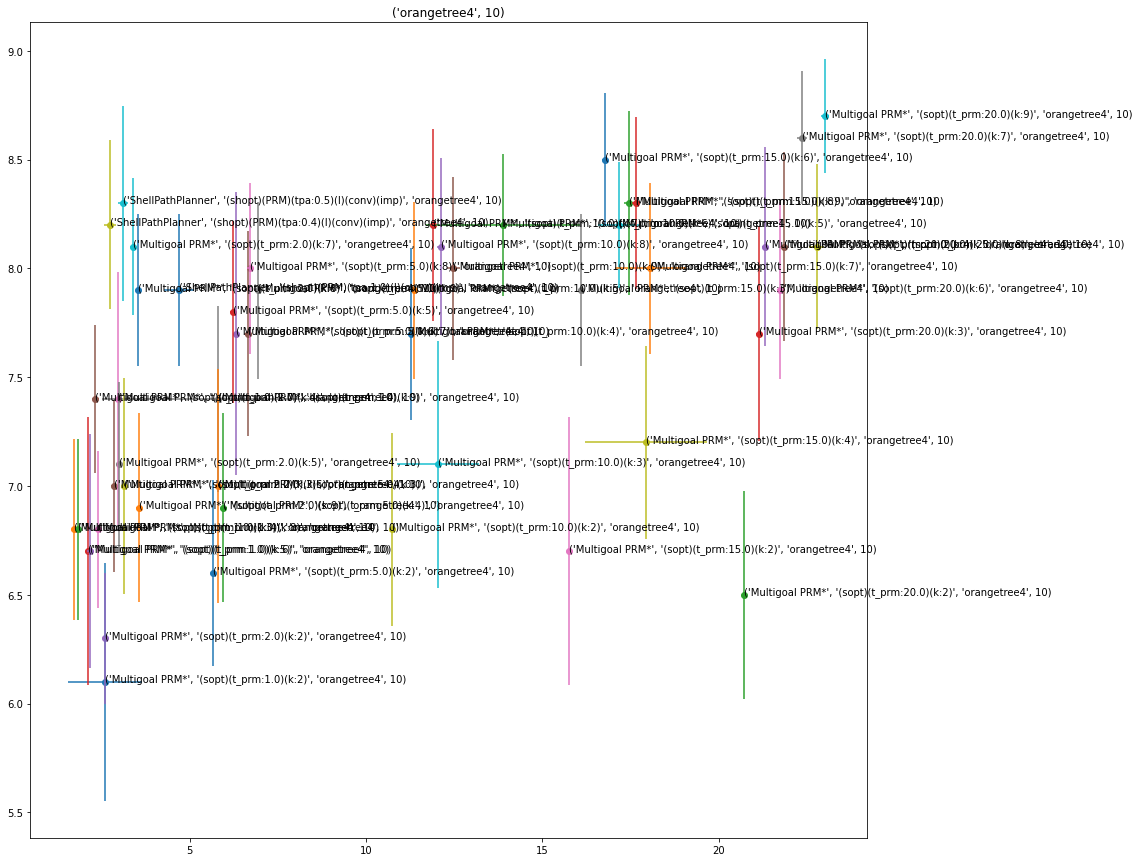

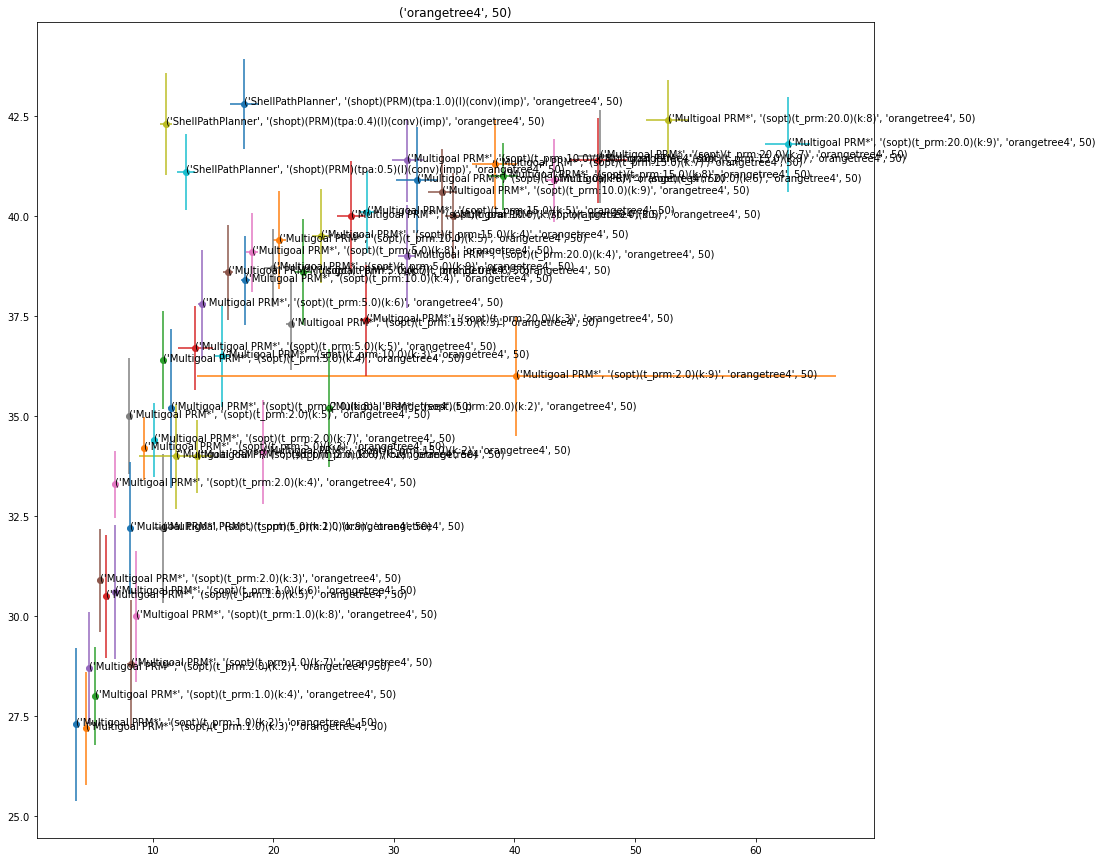

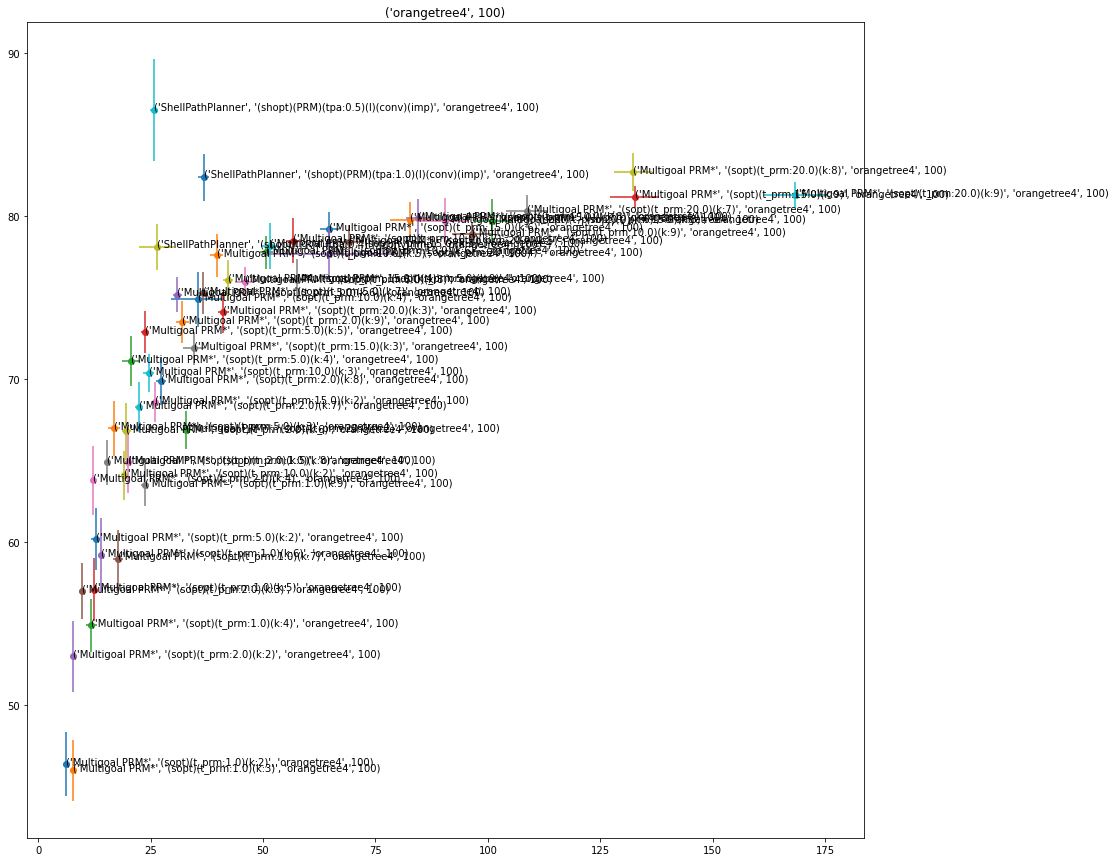

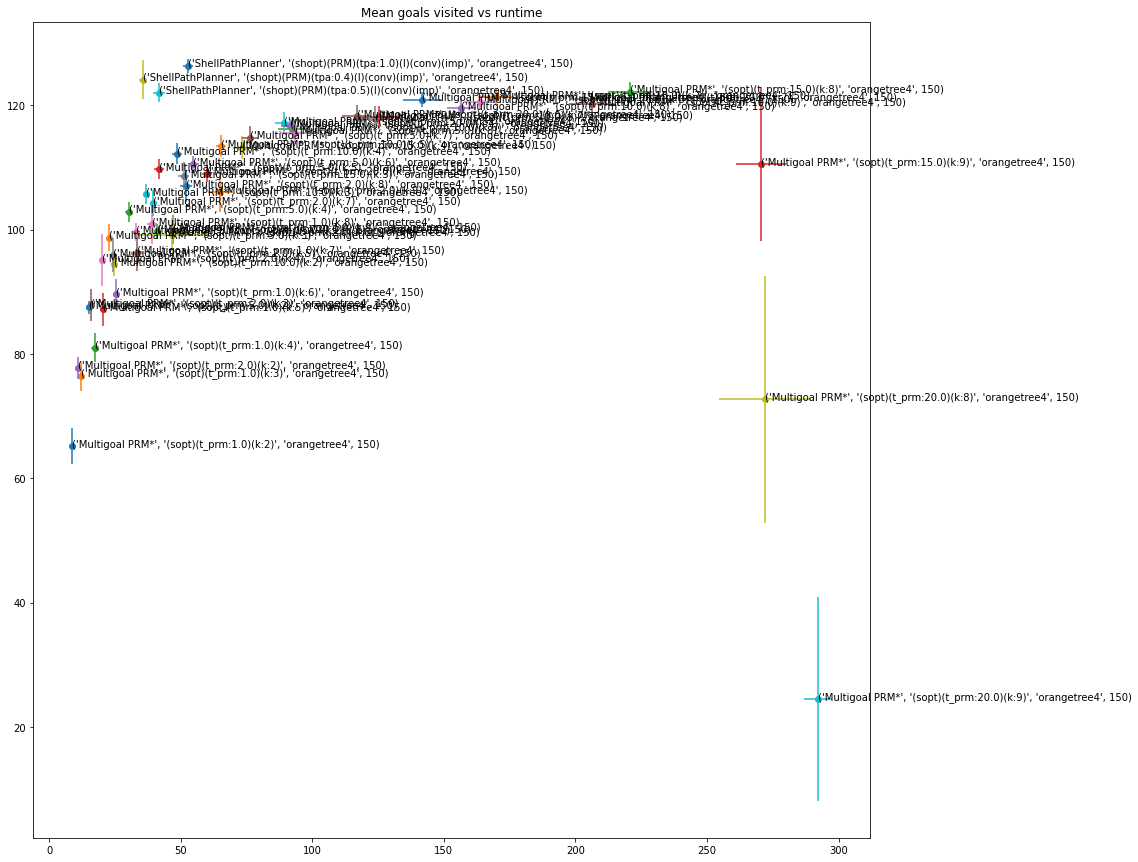

In [6]:
for i,(scene,scene_agged) in enumerate(agged.groupby(['scene','n'])):
    
    plt.figure(figsize=(15,15))
    plt.title(str(scene))
    
    for index,row in scene_agged.iterrows():

        x,xerr=row['run_time']
        y,yerr=row['goals_visited']

        plt.scatter(x,y)
        plt.errorbar(x,y,xerr=xerr,yerr=yerr)

        plt.annotate(str(index), (x,y))

plt.title('Mean goals visited vs runtime')

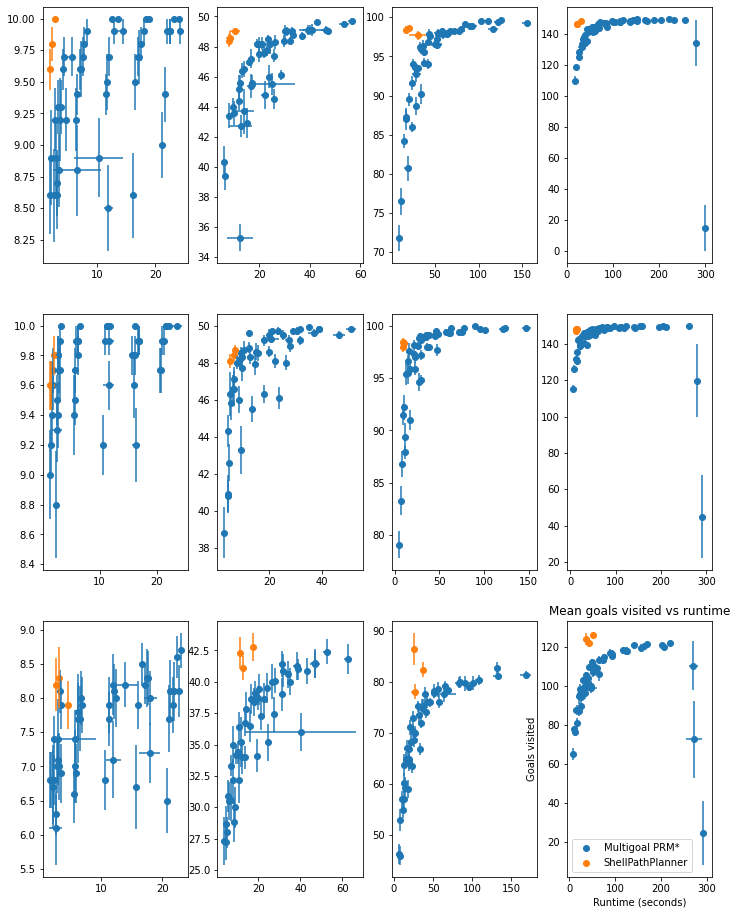

In [7]:
plt.figure(figsize=(12,16))

for i,(scene,scene_agged) in enumerate(agged.groupby(['scene','n'])):
    
    plt.subplot(3,len(n_unique),i+1)
    
    for planner,data in scene_agged.groupby('planner'):
        x=data['run_time']['mean']
        xerr=data['run_time']['sem']

        y=data['goals_visited']['mean']
        yerr=data['goals_visited']['sem']

        plt.scatter(x,y,label=planner)
        plt.errorbar(x,y,xerr=xerr,yerr=yerr,fmt='',linestyle='')

plt.title('Mean goals visited vs runtime')
plt.xlabel('Runtime (seconds)')
plt.ylabel('Goals visited')
plt.legend()

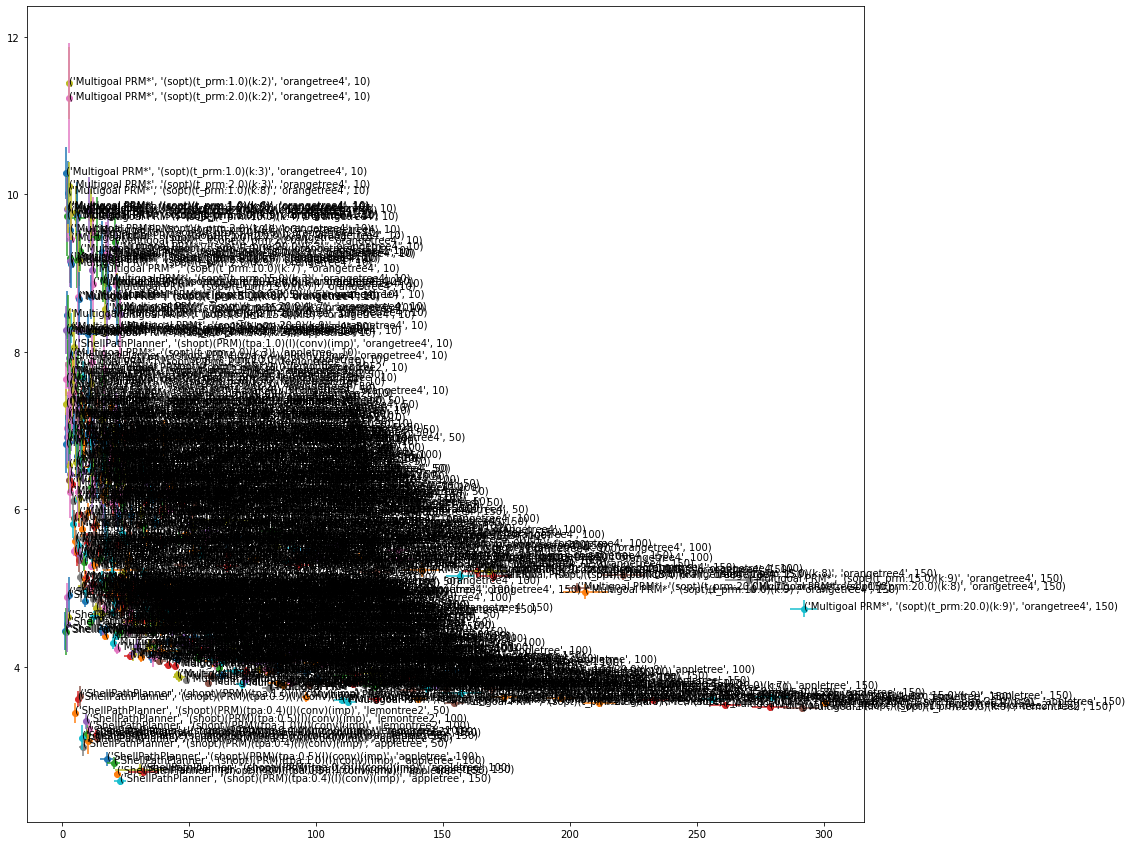

In [8]:
plt.figure(figsize=(15,15))

for index,row in agged.iterrows():
    
    x,xerr=row['run_time']
    y,yerr=row['length_per_target']
    
    plt.scatter(x,y)
    plt.errorbar(x,y,xerr=xerr,yerr=yerr)
    
    plt.annotate(str(index), (x,y))
    

/usr/lib/python3/dist-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/usr/lib/python3/dist-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


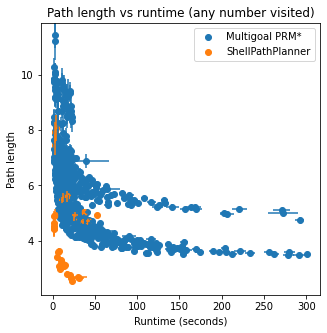

In [9]:
plt.figure(figsize=(5,5))

for planner,data in agged.groupby('planner'):
    x=data['run_time']['mean']
    xerr=data['run_time']['sem']

    y=data['length_per_target']['mean']
    yerr=data['length_per_target']['sem']

    plt.scatter(x,y,label=planner)
    plt.errorbar(x,y,xerr=xerr,yerr=yerr,fmt='',linestyle='')

plt.title('Path length vs runtime (any number visited)')
plt.xlabel('Runtime (seconds)')
plt.ylabel('Path length')
plt.legend()

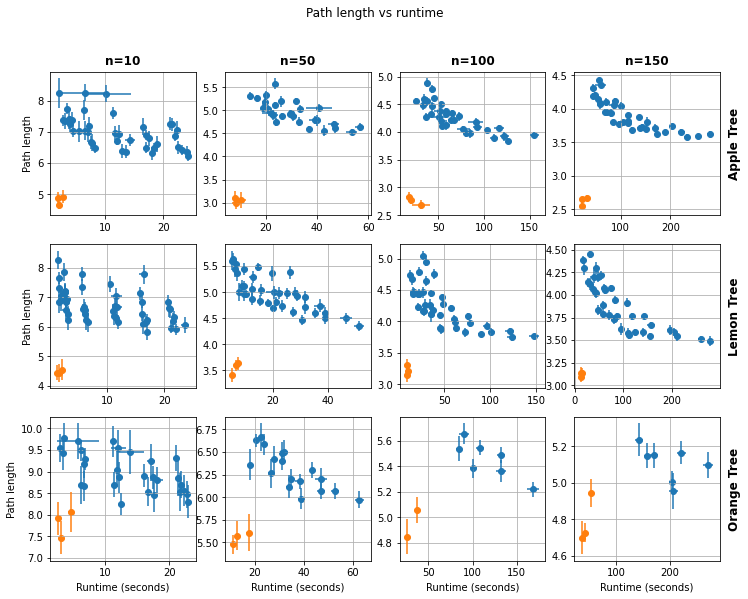

In [148]:
plt.figure(figsize=(12,9))

max_pct = dict(agged.groupby('scene').max()['pct_n']['mean'])

plt.suptitle('Path length vs runtime')

for i,((scene,n),scene_agged) in enumerate(agged.groupby(['scene','n'])):

    plt.subplot(3,4,i+1)

    for planner,data in scene_agged[scene_agged['pct_n']['mean']+scene_agged['pct_n']['sem']*1.96 >= max_pct[scene]-0.05].groupby('planner'):
        x=data['run_time']['mean']
        xerr=data['run_time']['sem']

        y=data['length_per_target']['mean']
        yerr=data['length_per_target']['sem']

        plt.scatter(x,y,label=planner)
        plt.errorbar(x,y,xerr=xerr,yerr=yerr,fmt='',linestyle='')
    
    if i >= 8:
        plt.xlabel('Runtime (seconds)')
    
    if i % 4 == 0:
        plt.ylabel('Path length')
    
    if i < 4:
        plt.annotate('n={}'.format(n),
                     (0.5,1.05), 
                     xycoords='axes fraction', 
                     horizontalalignment='center',
                     fontsize='large',
                     fontweight='bold')
    
    if (i+1) % 4 == 0:
        plt.annotate({'appletree': 'Apple Tree',
                      'lemontree2': 'Lemon Tree',
                      'orangetree4': 'Orange Tree'}[scene],
                     (1.1, 0.5), 
                     xycoords='axes fraction', 
                     horizontalalignment='center',
                     verticalalignment='center',
                     rotation=90,
                     fontsize='large',
                     fontweight='bold')

    plt.grid()
    
plt.savefig('grid_n_scene.pdf')

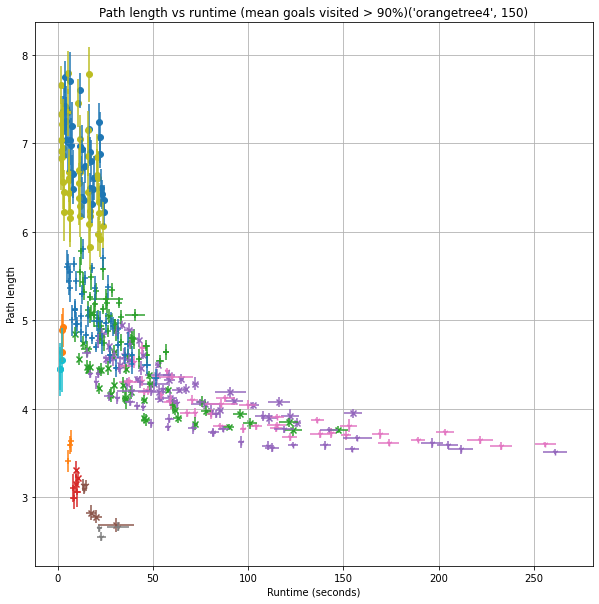

In [27]:
markers = ['o','x','+','1']

plt.figure(figsize=(10,10))


for i,((scene,n),scene_agged) in enumerate(agged.groupby(['scene','n'])):

    for planner,data in scene_agged[scene_agged['pct_n']['mean'] > 0.9].groupby('planner'):
        x=data['run_time']['mean']
        xerr=data['run_time']['sem']

        y=data['length_per_target']['mean']
        yerr=data['length_per_target']['sem']

        plt.scatter(x,y,label=planner,marker=markers[list(n_unique).index(n)])
        plt.errorbar(x,y,xerr=xerr,yerr=yerr,fmt='',linestyle='')

plt.title('Path length vs runtime (mean goals visited > 90%)' +str((scene,n)))
plt.xlabel('Runtime (seconds)')
plt.ylabel('Path length')
plt.grid()

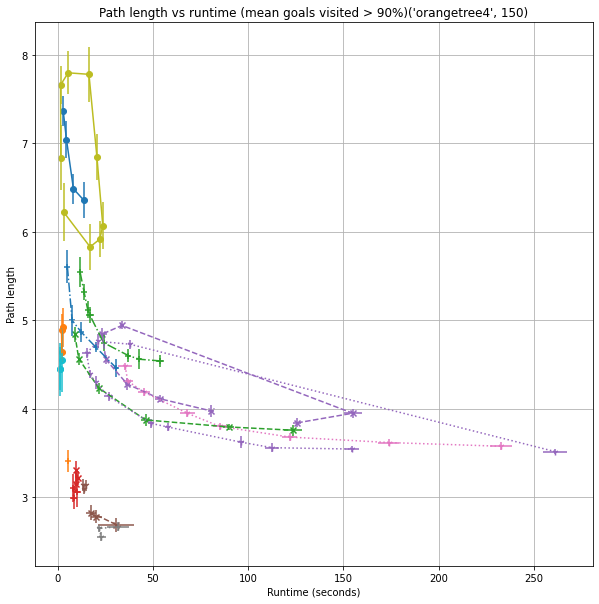

In [61]:
from scipy.spatial import ConvexHull

markers = ['o','x','+','1']
linetypes = ['-', '--', '-.', ':']

plt.figure(figsize=(10,10))


for i,((scene,n),scene_agged) in enumerate(agged.groupby(['scene','n'])):

    for planner,data in scene_agged[scene_agged['pct_n']['mean'] > 0.9].groupby('planner'):
        x=data['run_time']['mean']
        xerr=data['run_time']['sem']

        y=data['length_per_target']['mean']
        yerr=data['length_per_target']['sem']
        
        ch = ConvexHull(np.array([x,y]).T)
        
        x = x[ch.vertices]
        y = y[ch.vertices]
        xerr = xerr[ch.vertices]
        yerr = yerr[ch.vertices]
        
        leftmost = x.argmin()
        rightmost = x.argmax()
        
        if leftmost < rightmost:
            x = x[leftmost:rightmost]
            y = y[leftmost:rightmost]
            xerr = xerr[leftmost:rightmost]
            yerr = yerr[leftmost:rightmost]
#         else:
#             print(rightmost)
#             x = x[:rightmost] + x[leftmost:]
#             y = y[:rightmost] + y[leftmost:]
#             xerr = xerr[:rightmost] + xerr[leftmost:]
#             yerr = yerr[:rightmost] + yerr[leftmost:]
        

        plt.scatter(x,y,
                    label=planner,
                    marker=markers[list(n_unique).index(n)])
        
        plt.errorbar(x,y,xerr=xerr,yerr=yerr,fmt='',ls=linetypes[list(n_unique).index(n)])

plt.title('Path length vs runtime (mean goals visited > 90%)' +str((scene,n)))
plt.xlabel('Runtime (seconds)')
plt.ylabel('Path length')
plt.grid()